### Cinema Business Overview

Nowaday exists a variety of offers in the bussines of films and movies, specially when we look the Internet and platforms of entertainment. 
But the cinemas are the physical place wehere people enjoy the service with diferent characterstics and experiences that we do not find in internet
cinemas have probably experienced a decrease in sales caused for that, then is important to analyze this market and to do a predictive modeling that shows
us how is moving through the time and identify patterns or possible oportunities that allow to manage in better way the incomes to get more benfits.

In the analysis we gonna try to use time series predictive analysis and machine learning tools to implement sales forecast.

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


##### 1) Data exploration


We gonna try to understand the objective of the analysis answering to the folowing questions:

our objective is to increase the Total Sales and identify factors that contribuite to more sold tickets

1) What are the films that reach greatest number of sold tickets?
2) Which features are the most relevant and strongly correlated with the sales?
3) Are there any patterns that allow ourselves understand more about what's happening with that correlation?
4) From that films that are the most viewed, Are there any pattern that we could identify eg: Actors in the movie, duration, Category of the movie, influencers or music stars in the movie.
5) 

In [4]:
df = pd.read_csv("cinemaTicket_Ref.csv")
df.head(5)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [5]:
# Creating a new ID code for cinemas and film code

df["unique_id"] = df[["film_code", "cinema_code", "date"
                      ]].apply(lambda row: "_".join(row.values.astype(str)),
                               axis=1)
# Move to first column the column "Unique id"
df = df[["unique_id"] + [col for col in df.columns if col != "unique_id"]]


In [6]:
df.info()
# The date column has object type, we gonna change this type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   unique_id     142524 non-null  object 
 1   film_code     142524 non-null  int64  
 2   cinema_code   142524 non-null  int64  
 3   total_sales   142524 non-null  int64  
 4   tickets_sold  142524 non-null  int64  
 5   tickets_out   142524 non-null  int64  
 6   show_time     142524 non-null  int64  
 7   occu_perc     142399 non-null  float64
 8   ticket_price  142524 non-null  float64
 9   ticket_use    142524 non-null  int64  
 10  capacity      142399 non-null  float64
 11  date          142524 non-null  object 
 12  month         142524 non-null  int64  
 13  quarter       142524 non-null  int64  
 14  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 16.3+ MB


In [7]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True, format=r"%Y-%m-%d")

C:\Users\Binicio\AppData\Local\Temp\ipykernel_15496\4026880088.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='spearman'),


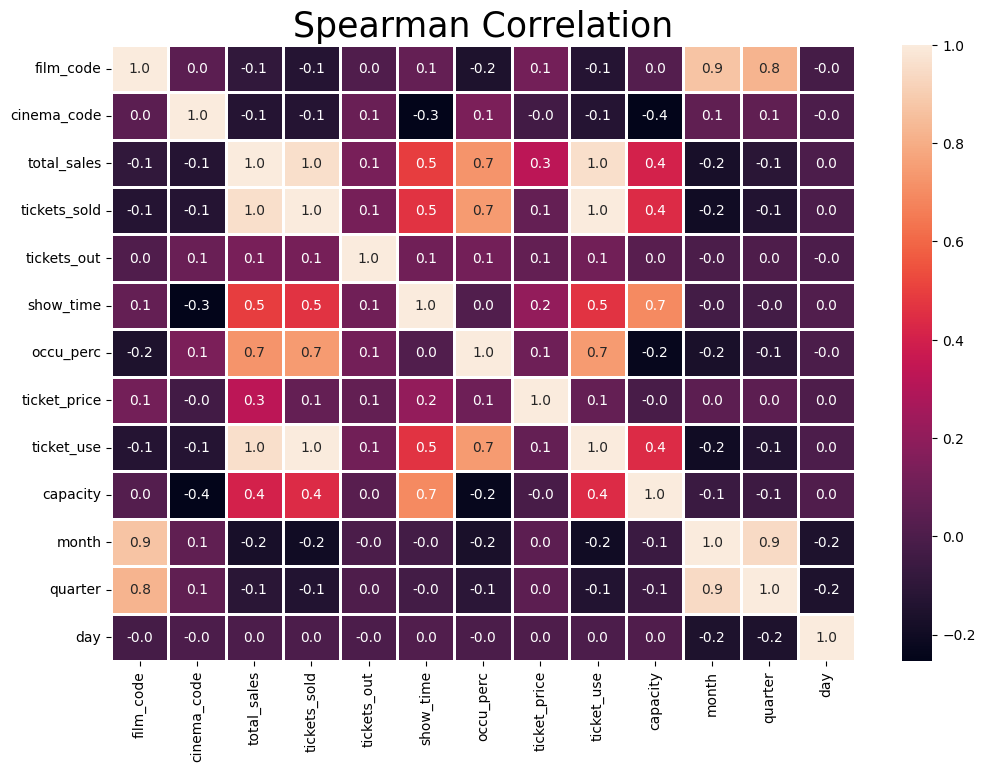

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'),
            linewidths=1,
            annot=True,
            robust=True,
            annot_kws={'size': 10},
            fmt=".1f")
plt.title('Spearman Correlation', fontsize=25)
plt.show()


In [9]:
def nulls(df, df_name):

    if df.isnull().values.any() == False:
        print(f"NULLS: There isn't null values in:{df_name}")

    else:
        print("NULLS: There is nulls values")
        null_columns = df.columns[df.isnull().any()].tolist()

        for column in null_columns:
            nulls = df[column].isna().sum()
            percent = round((nulls / len(df)), 4) * 100
            print(
                f" [{column}] has:  nulls number: {nulls} | nulls % : {percent}%"
            )


def duplicates(df, column):
    num_dup = df.duplicated(subset=[column]).sum()

    if df.duplicated(subset=[column]).sum() != 0:
        a = df.duplicated(subset=[column]).sum()
        print(f"There are '{a}' duplicated values:")

def visual_distr(df, col):

    variable = df[col].values
    plt.figure(figsize=(12, 4))
    sns.displot(variable)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f"{col}")

    return plt.show()

<Figure size 1200x400 with 0 Axes>

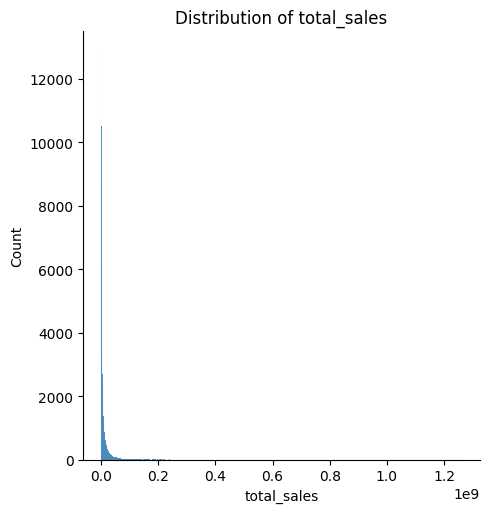

In [10]:
visual_distr(df, 'total_sales')

In [11]:
nulls(df, "Main Dataframe")
print("------------------------------------------" + "\n DUPLICATES:")
duplicates(df, "unique_id")

NULLS: There is nulls values
 [occu_perc] has:  nulls number: 125 | nulls % : 0.09%
 [capacity] has:  nulls number: 125 | nulls % : 0.09%
------------------------------------------
 DUPLICATES:
There are '106' duplicated values:


1260000.0 11100000.0
lower-bound:-13500000.0 
 upper-bound:25860000.0


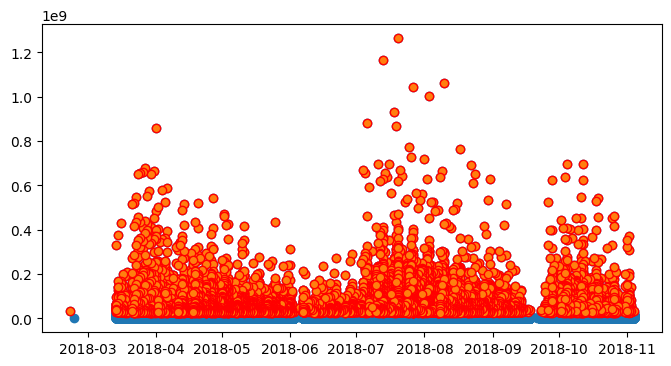

In [12]:
quantile1, quantile3 = np.percentile(df['total_sales'], [25, 75])
print(quantile1, quantile3)

iqr_value = quantile3 - quantile1

lower_bound = quantile1 - (1.5 * iqr_value)
upper_bound = quantile3 + (1.5 * iqr_value)

print(f"lower-bound:{lower_bound}","\n",f"upper-bound:{upper_bound}")

plt.figure(figsize=(8, 4))
plt.scatter(df.values[:, 11], df.values[:, 3])
ub_date = df[df['total_sales'] > upper_bound].values[:, 11]
ub_sales = df[df['total_sales'] > upper_bound].values[:, 3]
plt.scatter(ub_date, ub_sales, edgecolor='r')


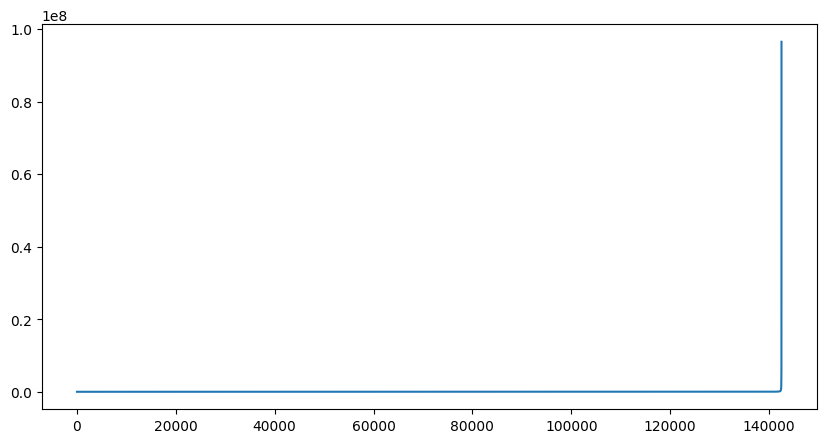

In [13]:
#Applying Knearest Kneighboors to know what eps= parameter is suitable.
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import time

#First we convert to ordinal type the date to pass into array and fit the model.
df['toordinal'] = df['date'].apply(lambda x: x.toordinal())

neigh = NearestNeighbors(n_neighbors=2)

X = np.array([df.total_sales.values, df.toordinal.values]).T #Tranpose an array to get the correct dimension to pass through the function kneighboors
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(distances)

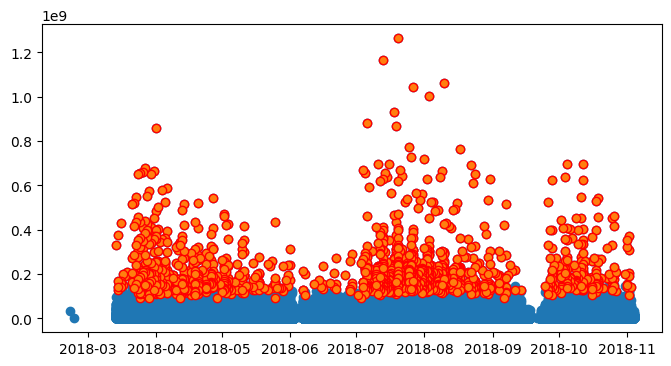

In [14]:
from sklearn.cluster import DBSCAN

# We took 147000 at the maximum curvature to use as epsilon parameter
dbscan = DBSCAN(eps=147000, min_samples=10)
dbscan.fit(df['total_sales'].values.reshape(-1, 1))

labels = dbscan.labels_
df['dbscan_score'] = labels
df_dbscan = df[df['dbscan_score'] < 0]

plt.figure(figsize=(8, 4))
plt.scatter(df.values[:, 11], df.values[:, 3])
dbscan_date = df_dbscan[df_dbscan['total_sales'] > 1].values[:, 11]
dbscan_sales = df_dbscan[df_dbscan['total_sales'] > 1].values[:, 3]
plt.scatter(dbscan_date, dbscan_sales, edgecolor='r')


##### 2) Preprocessing and Data Cleaning


In [15]:
df=df.drop_duplicates('unique_id')
df.dropna(axis=1, inplace=True)

In [16]:
df = df[df['dbscan_score'] >= 0]

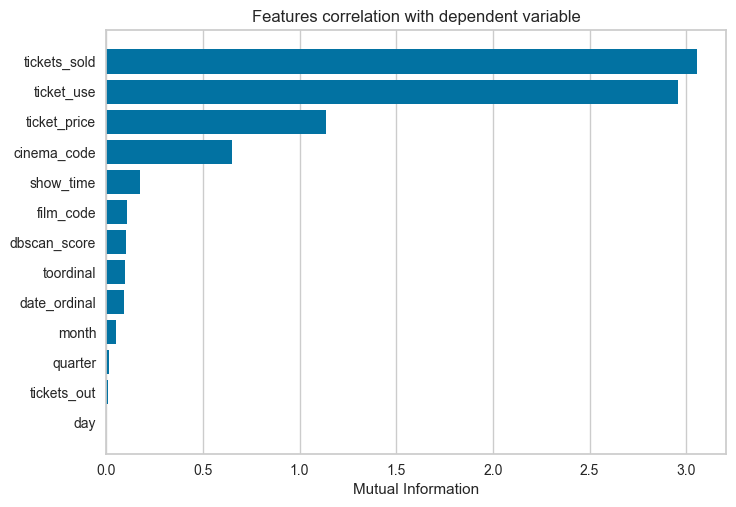

<AxesSubplot: title={'center': 'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [17]:
from yellowbrick.target import FeatureCorrelation

df['date_ordinal']=df.loc[:,'date'].apply(lambda x: x.toordinal())
features_names=list(df.drop(['total_sales', 'date', 'unique_id'], axis=1).columns)
X=df.drop(['total_sales', 'date', 'unique_id'], axis=1)
y=df['total_sales']

visualizer=FeatureCorrelation(method='mutual_info-regression',labels=features_names, sort=True)
visualizer.fit(X,y)

visualizer.show()

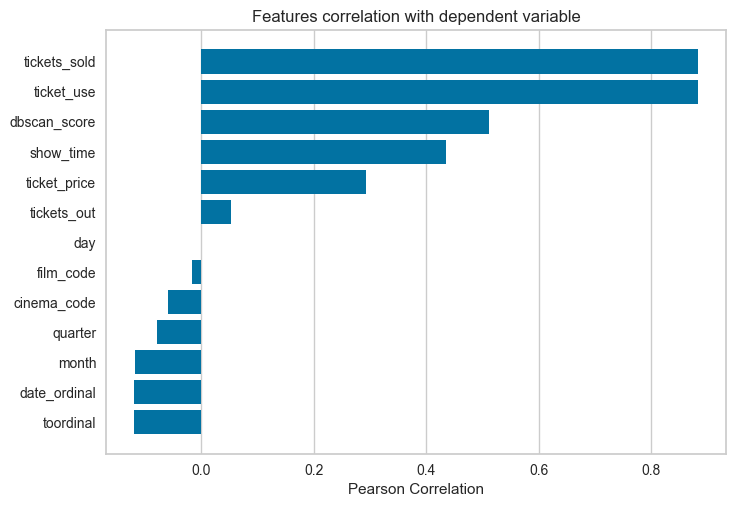

<AxesSubplot: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [18]:

visualizer=FeatureCorrelation(method='pearson',labels=features_names, sort=True)
visualizer.fit(X,y)

visualizer.show()

In [20]:
df

,unique_id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,ticket_price,ticket_use,date,month,quarter,day,toordinal,dbscan_score,date_ordinal
0,1492_304_2018-05-05,1492,304,3900000,26,0,4,150000.0,26,2018-05-05,5,2,5,736819,0,736819
1,1492_352_2018-05-05,1492,352,3360000,42,0,5,80000.0,42,2018-05-05,5,2,5,736819,0,736819
2,1492_489_2018-05-05,1492,489,2560000,32,0,4,80000.0,32,2018-05-05,5,2,5,736819,0,736819
3,1492_429_2018-05-05,1492,429,1200000,12,0,1,100000.0,12,2018-05-05,5,2,5,736819,0,736819
4,1492_524_2018-05-05,1492,524,1200000,15,0,3,80000.0,15,2018-05-05,5,2,5,736819,0,736819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1569_495_2018-11-04,1569,495,1320000,22,0,2,60000.0,22,2018-11-04,11,4,4,737002,0,737002
142520,1569_474_2018-11-04,1569,474,1200000,15,0,1,80000.0,15,2018-11-04,11,4,4,737002,0,737002
142521,1569_524_2018-11-04,1569,524,1060000,8,0,3,132500.0,8,2018-11-04,11,4,4,737002,0,737002
142522,1569_529_2018-11-04,1569,529,600000,5,0,2,120000.0,5,2018-11-04,11,4,4,737002,0,737002


<AxesSubplot: xlabel='total_sales', ylabel='Count'>

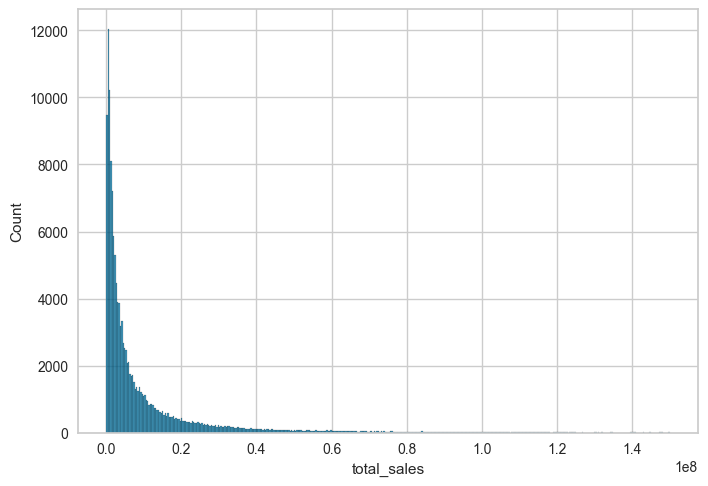

In [23]:
sns.histplot(df['total_sales'])

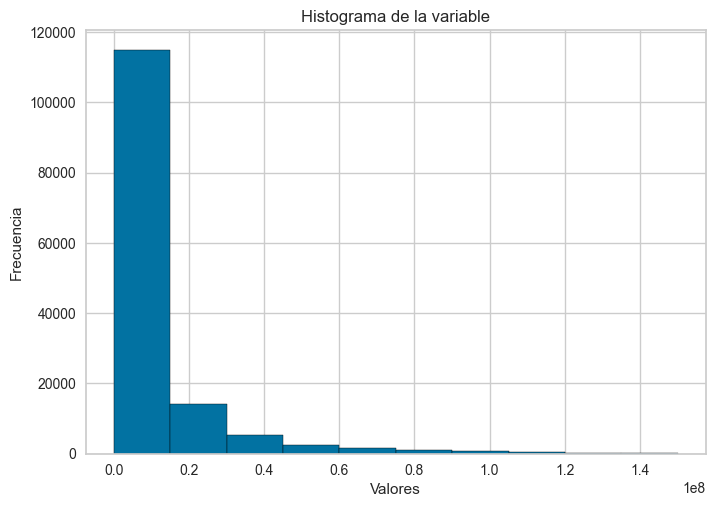

In [24]:
plt.hist(df['total_sales'], bins=10, edgecolor='black')  # bins es el número de barras o "cajas" en el histograma
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable')
plt.show()

In [27]:
df['total_sales'].mean()


10036220.856527204

In [28]:
df['total_sales'].median()


3610000.0

In [29]:
df['total_sales'].mode()

0    600000
Name: total_sales, dtype: int64